In [1]:
# 1. Import thư viện cần thiết

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,10198.599609,11046.700195,9694.650391,10975.599609,10975.599609,6783119872
2017-12-02,10978.299805,11320.200195,10905.099609,11074.599609,11074.599609,5138500096
2017-12-03,11082.700195,11858.700195,10862.000000,11323.200195,11323.200195,6608309760
2017-12-04,11315.400391,11657.200195,11081.799805,11657.200195,11657.200195,6132409856
2017-12-05,11685.700195,12032.000000,11604.599609,11916.700195,11916.700195,6895260160


In [3]:
df1 = df[['Close']]
df1 = df1.dropna() # Drop missing values

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [22]:
# 4. Chia train test theo tỉ lệ 7:2:1
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [23]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [24]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [25]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [26]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 4s 99ms/step - loss: 0.0014 - val_loss: 0.1611
Epoch 2/100
15/15 [==============================] - 1s 74ms/step - loss: 4.8998e-04 - val_loss: 0.0662
Epoch 3/100
15/15 [==============================] - 1s 70ms/step - loss: 1.9155e-04 - val_loss: 0.0179
Epoch 4/100
15/15 [==============================] - 1s 71ms/step - loss: 7.1059e-05 - val_loss: 0.0022
Epoch 5/100
15/15 [==============================] - 2s 108ms/step - loss: 4.9609e-05 - val_loss: 0.0018
Epoch 6/100
15/15 [==============================] - 2s 108ms/step - loss: 4.6752e-05 - val_loss: 0.0019
Epoch 7/100
15/15 [==============================] - 1s 69ms/step - loss: 4.5684e-05 - val_loss: 0.0020
Epoch 8/100
15/15 [==============================] - 1s 69ms/step - loss: 4.4441e-05 - val_loss: 0.0019
Epoch 9/100
15/15 [==============================] - 1s 68ms/step - loss: 4.3244e-05 - val_loss: 0.0019
Epoch 10/100
15/15 [==============================] - 1s 68ms/step

In [28]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

10/10 [==============================] - 0s 20ms/step


In [29]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

**Đánh giá trên tập test với tỉ lệ 5:3:2**

In [30]:
mse = mean_squared_error(ytest, y_pred)
rmse =np.sqrt(mse)
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

MSE: 2039954757.7255132
RMSE: 45165.858319371204
MAE: 44198.49992588955
MAPE: 68107.95265821752


**Đánh giá trên tập test với tỉ lệ 6:2:2**

In [21]:
mse = mean_squared_error(ytest, y_pred)
rmse =np.sqrt(mse)
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

MSE: 2176168625.4794793
RMSE: 46649.422563194494
MAE: 45949.36157371117
MAPE: 69345.1958966177


**Đánh giá trên tập test với tỉ lệ 7:2:1**

In [13]:
mse = mean_squared_error(ytest, y_pred)
rmse =np.sqrt(mse)
mae = mean_absolute_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape * 100)

MSE: 922187047.0261885
RMSE: 30367.532778054072
MAE: 28840.276054598853
MAPE: 7489570.534354879


**Đồ thị so sánh giá trị thực tế và dự đoán trên tập test và vaildate với tỉ lệ 6:2:2**

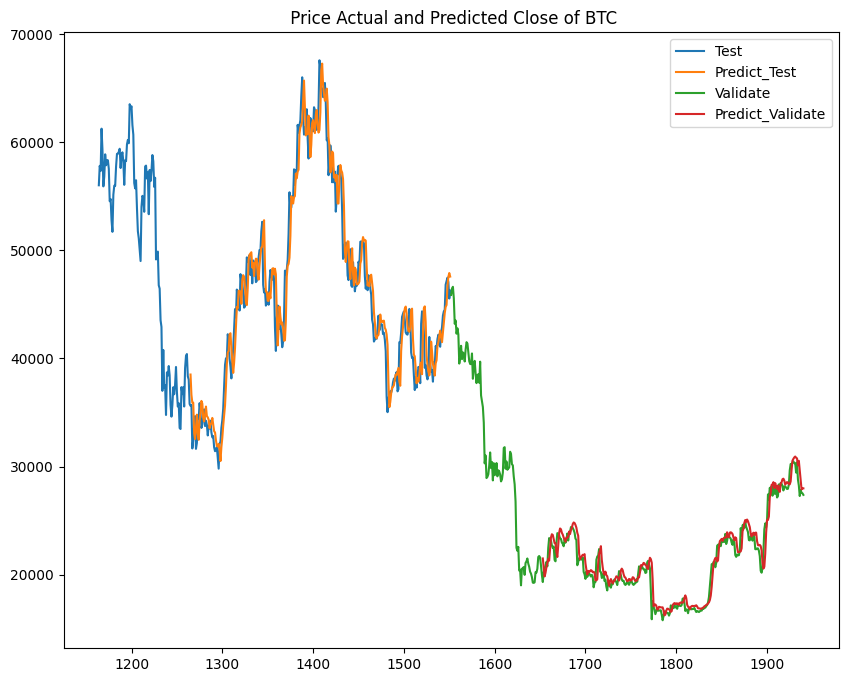

In [ ]:
# 9.Vẽ hình
plt.figure(figsize=(10,8))
plt.title(' Price Actual and Predicted Close of BTC')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Test','Predict_Test','Validate','Predict_Validate'])
plt.show()

**Đồ thị so sánh giá trị thực tế và dự đoán trên tập test và vaildate với tỉ lệ 7:2:1**

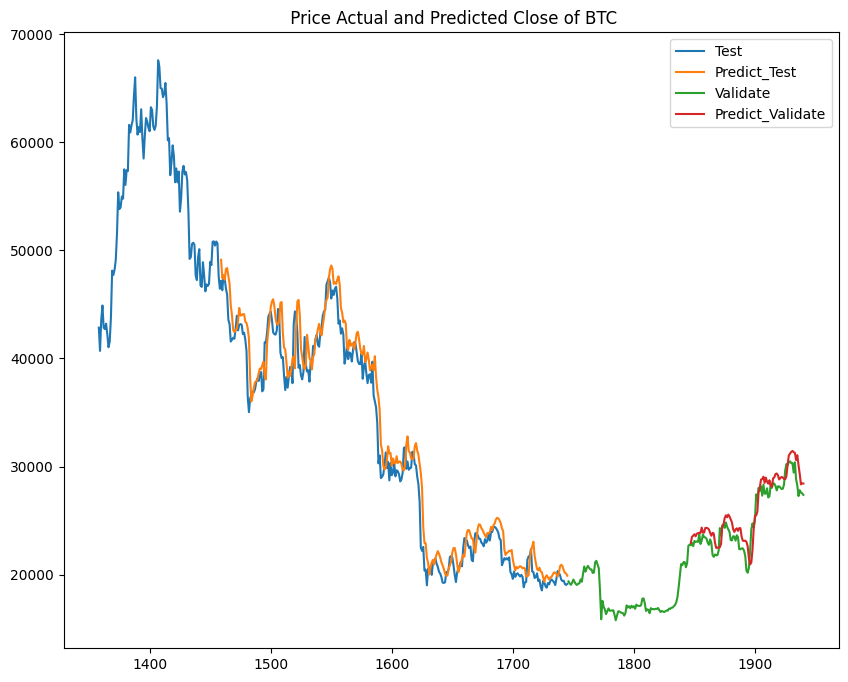

In [ ]:
# 9.Vẽ hình
plt.figure(figsize=(10,8))
plt.title(' Price Actual and Predicted Close of BTC')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Test','Predict_Test','Validate','Predict_Validate'])
plt.show()

**Dự đoán giá trị 30 ngày với tỉ lệ 6:2:2**

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=327
i=0
while(i<30):

    if(len(temp_input)>300):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


**Dự đoán giá trị 30 ngày với tỉ lệ 7:2:1**

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=133
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.22609267 0.22662636 0.21961898 0.20846742 0.21076195 0.210185
 0.20523713 0.21249073 0.21111083 0.2113099  0.21079088 0.2115806
 0.21149092 0.21270059 0.20955073 0.20699202 0.20838747 0.20776948
 0.20691311 0.20811914 0.20910454 0.20897065 0.21182127 0.2114093
 0.21320057 0.21324891 0.21536404 0.21700262 0.22088476 0.22848002
 0.24300964 0.25917605 0.2757581  0.27427357 0.27876345 0.27863733
 0.27128869 0.27747572 0.30218826 0.30375941 0.30287011 0.30619695
 0.30156516 0.3090483  0.30772571 0.30844002 0.30769948 0.3192567
 0.30473118 0.30938133 0.31846707 0.31455135 0.31420083 0.31237471
 0.30652703 0.30348714 0.31132456 0.30627415 0.28885836 0.28624907
 0.28966414 0.28837902 0.28868834 0.29510374 0.32754638 0.316908
 0.33155321 0.33272957 0.32785418 0.33565    0.32954407 0.32569657
 0.3219448  0.31029605 0.30994237 0.31594016 0.31534414 0.30950678
 0.31726672 0.31460725 0.29730916 0.29716412 0.29844135 0.29835188
 0.29508765 0.28728897 0.26622481 0.26349238 0.27041241 0

ValueError: ignored

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()